#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Homework 6
### Due: Monday, Mar 14th at 11.00am CST

The completed lecture notebook must also be submitted by 11:00am Central Time on March 14th (after Spring Break).

---

##### Problem 1

**The Leavitt Law**

Cepheid variable stars in galaxies follow a linear relation between their log periods, log metallicity, and apparent magnitude (the Leavitt law):

$m_i^W = zp_{W,N4258} + b_W \log P_i + Z_w \Delta \log (O/H)_i \;\;\; (1)$

where 
$m^W = m_H - 0.39(V-I)$

and is called the "Wesenheit magnitude".

The index $i$ here denotes the individual Cepheids in a sample.


Download table 4 from Riess et al. (2016):

https://ui.adsabs.harvard.edu/abs/2016yCat..18260056R/abstract

You will find the tables here:
https://cdsarc.cds.unistra.fr/viz-bin/cat/J/ApJ/826/56#/browse
Table descriptions are in the readme file.

Use the data for Cepheids in NGC 4258 from Table 4. Assuming that there is no intrinsic scatter in the Leavitt law, the parameters
of Equation (1) can be determined through ordinary least squares. Determine the best-fit
parameters $zp_{W,N4258}$, $b_W$, and $Z_w$ and their Gaussian covariance matrix. Plot the data $m^W_i$ vs. $\log_{10} P_i$ and overlay the best fit model (evaluated at the mean metallicity of the sample).








In [1]:
#Import all libraries for hw
import numpy as np
import pandas as pd
import math
from scipy.optimize import curve_fit
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

### Solution

In [2]:
#Read in cepheid NGC 4258 datat
url = 'https://cdsarc.cds.unistra.fr/ftp/J/ApJ/826/56/table4.dat'
col = ["Field", "RAdeg", "DEdeg", "ID", "Per", "V-I", "F160W", "sigTot", "del log(O/H)"]
df = pd.read_table(url, names = col, delim_whitespace=True)
df["logPi"]=df["Per"].apply(lambda x: math.log10(x))
display(df.iloc[:5].style.hide_index())

Field,RAdeg,DEdeg,ID,Per,V-I,F160W,sigTot,del log(O/H),logPi
M101,210.879790,54.333760,115287,17.950000,0.960000,22.470000,0.300000,9.134000,1.254064
M101,210.891270,54.356200,136682,5.358000,1.060000,24.410000,0.570000,9.118000,0.729003
M101,210.892270,54.361250,148312,11.860000,1.070000,22.940000,0.320000,9.113000,1.074085
M101,210.893510,54.368260,164932,14.920000,1.130000,23.030000,0.320000,9.105000,1.173769
M101,210.879820,54.335650,121146,11.860000,0.960000,23.140000,0.450000,9.136000,1.074085


In [3]:
#Fit parameters to model Leavitt law model
def leavitt_law(x, zp, b, zw):
    pwi = x[0]
    OH = x[1]
    return zp + b * pwi + zw * OH

y = df["F160W"].values
x = [df["logPi"].values,df["del log(O/H)"].values]
popt, pcov = curve_fit(leavitt_law, x, y)

print("Parameters (𝑧𝑝𝑊,𝑁4258, 𝑏𝑊, and 𝑍𝑤): \n", popt)
print("Covariance matrix: \n",pcov)

Parameters (𝑧𝑝𝑊,𝑁4258, 𝑏𝑊, and 𝑍𝑤): 
 [23.75988994  3.29303047 -0.59523081]
Covariance matrix: 
 [[ 9.01640447 -0.12791561 -0.99250138]
 [-0.12791561  0.02722505  0.01036107]
 [-0.99250138  0.01036107  0.10983245]]


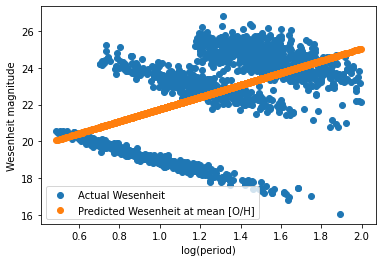

In [4]:
#Predicted Wesenheit magnitude values at mean metallicity
meanMetallicity = df["del log(O/H)"].mean()
zp = popt[0]
b = popt[1]
zw = popt[2]
df["predictedF160W@mean"] =df["logPi"].apply(lambda logPi: leavitt_law([logPi, meanMetallicity], zp, b, zw))

#Plot actual Wesenheit magnitude values
x = df["logPi"]
y = df["F160W"]
plt.scatter(x,y)

#Plot predicted Wesenheit magnitude values
yPredictedAtMean = df["predictedF160W@mean"]                                              
plt.scatter(x,yPredictedAtMean)
plt.ylabel("Wesenheit magnitude")
plt.xlabel("log(period)")
plt.legend(['Actual Wesenheit', 'Predicted Wesenheit at mean [O/H]'])

## Problem 2

**Posterior probability distribution of binomial distribution**

Given a set of $N$ measurements, $x_i$, drawn from a binomial distribution described with parameter $b$, we seek the posterior probability distribution $p(b|x_i)$.

When $N$ is large, $b$ and its (presumably Gaussian) uncertainty $\sigma_b$ can be determined using the equation above. For small $N$, the proper procedure is as follows. Assuming that the prior for $b$ is at in the range 0-1, the posterior probability for $b$ is

$$p(b|k,N) = C b^k (1-b)^{N-k}$$

where $k$ is now the actual observed number of successes in a data set of $N$ values, and $C$ is a normalization factor with can be determined from the condition

$$\int_0 ^1 p(b|k,N)db=1.$$

The maximum posterior occurs at $b_0 = k/N$.

Write code for calculating the posterior distribution.
Vary the value $b$ and draw the resulted posterior probability distribution from our data set. 

In comparison, also calculate a Gaussian distribution from the same data set.


### Solution



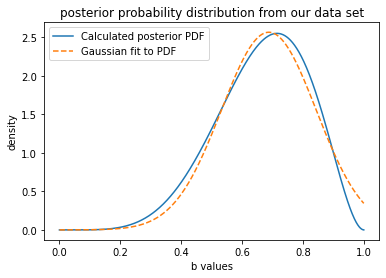

In [5]:
#Set parameters
k = 5
N = 7

#Posterior PDF calculation
def posteriorForm(b, k, N):
    return (b**k)*(1-b)**(N-k)
    
def posteriorDist(N, k):
    stepSize = .001
    bList = np.arange(0,1,stepSize)
    yValue = []
    for b in bList:
        yValue.append(posteriorForm(b, k, N))
    yValue = yValue/(sum(yValue)*stepSize)
    return bList, yValue

x,y =posteriorDist(N, k)

#Guassian approxmation of PDF
def normal_dist(x,mean,sd):
    a = 1/(sd*math.sqrt(2*np.pi))
    b = np.exp(-0.5*((x-mean)/sd)**2)
    return a*b

b0   = k/N #Used to make starting guess for mean
popt, pcov = curve_fit(normal_dist, x, y, p0 = [b0,.1])
mean = popt[0]
sd   = popt[1]
pdf  = stats.norm(mean, sd).pdf(x)


#Plotting
plt.plot(x,y) #posterior 
plt.plot(x, pdf, '--') #Gaussian approximation
plt.title("posterior probability distribution from our data set")
plt.xlabel("b values")
plt.ylabel("density")
plt.legend(['Calculated posterior PDF', 'Gaussian fit to PDF'])

Text(0, 0.5, 'density')

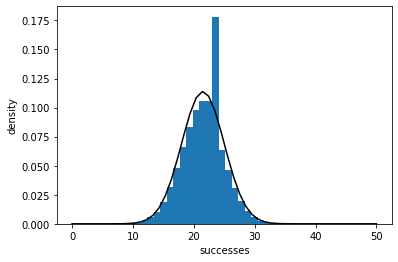

In [6]:
#Showing distribution after building random binomial dataset
k = 50
N = 1000000
b = 0.43

#Plot histogram of dataset
randDataset = np.random.binomial(k, b, N)
plt.hist(randDataset, bins = 30, density=True)

#Plot a fitted Gaussian
F_fit = np.linspace(0, k)
pdf = stats.norm(np.mean(randDataset), np.std(randDataset)).pdf(F_fit)
plt.plot(F_fit, pdf, '-k')
plt.xlabel("successes")
plt.ylabel("density")